In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

fourier_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_large.npy')
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [6]:
########################################################################à

In [7]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')], chunks={'time_counter':1, 'lev_W':1, 'y_grid_M':-1, 'x_grid_M':-1})
GPH_base = GPH_base['PHB']/9.81

In [8]:
GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')], chunks={'time_counter':1, 'lev_W':1, 'y_grid_M':-1, 'x_grid_M':-1})
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
GPH = GPH['PH']/9.81

In [9]:
GPH = GPH_base + GPH
GPH = GPH.transpose('lev_W', 'time_counter', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask_modified, drop=False)
GPH = GPH.resample(time_counter='24H').mean(dim = 'time_counter')

del GPH_base

In [10]:
# # vertical interpolation of geopotential
# # GPH_inter = np.zeros((39,29,546,573))
# # for i in range(39):
# #     GPH_inter[i,:,:,:] = (GPH[i+1,:,:,:]+GPH[i,:,:,:])*0.5

GPH_lower = GPH.isel(lev_W=slice(0, -1))
GPH_upper = GPH.isel(lev_W=slice(1, None))

# ## THERE WAS A MISMATCH BETWEEN THE lev_W labels
# ## this .data allows to disregard the labels (treats them as Numpy arrays)
GPH_inter = xr.DataArray(0.5*(GPH_lower.data + GPH_upper.data), dims=('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M'))


# del GPH_inter

In [15]:
print(GPH.dims)
print(GPH_inter.dims)


('lev_W', 'time_counter', 'y_grid_M', 'x_grid_M')
('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M')


In [11]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [12]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False)  #.values; 
# PBLH_day = PBLH_day.chunk({'day':1})

In [13]:
print(PBLH_day.dims)
PBLH_day = PBLH_day.rename({'day':'time_counter', 'y':'y_grid_M', 'x':'x_grid_M'})
print(PBLH_day.dims)

('day', 'y', 'x')
('time_counter', 'y_grid_M', 'x_grid_M')


In [14]:
PBLH_exp = PBLH_day.expand_dims(dim={"lev_M": GPH_inter.sizes["lev_M"]}, axis=0)

In [15]:
PBLH_exp = PBLH_exp.chunk({'lev_M':1, 'time_counter':1, 'y_grid_M':-1, 'x_grid_M':-1})

In [16]:
dZ = GPH.diff('lev_W', n=1)
if 'lev_W' in dZ.dims:
    dZ = dZ.rename({'lev_W':'lev_M'})

dZ = dZ.assign_coords({'time_counter': PBLH_exp.time_counter})

In [17]:
under_mabl = xr.where(GPH_inter <= PBLH_exp, 1.0, 0.0)
# under_mabl inherits the time_counter from PBLH_exp

### July 2025: analyze $\int_{MABL} \theta \, dz$ to link WRF to bulk model

In [18]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_M':-1, 'x_grid_M':-1})
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask_modified, drop=False)
# pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300.
pot_temp_full = pot_temp + T0
del pot_temp

In [19]:
theta_day = pot_temp_full.resample(time_counter='24H').mean(dim = 'time_counter');
theta_day = theta_day.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M')
del pot_temp_full

In [20]:
theta_day = theta_day.assign_coords({'time_counter': PBLH_exp.time_counter})

In [21]:
theta_day_avg = theta_day.where(under_mabl, drop=False).mean(dim='lev_M', skipna=True)

In [22]:
theta_day_avg.attrs['long name'] = 'average potential temperature within the simulated MABL depth'
theta_day_avg.attrs['units'] = '[K]'
theta_day_avg = theta_day_avg.chunk({'time_counter':1, 'y_grid_M':-1, 'x_grid_M':-1})


In [24]:
theta_day_avg.to_netcdf(path='/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.nc', compute=True)

In [6]:
# import zarr
# from pathlib import Path

# # Use DirectoryStore to avoid ambiguity
# store = zarr.DirectoryStore("/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.zarr")

# # 
# theta_day_avg.to_zarr(store="/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.zarr", mode="w", safe_chunks=False)

try to read this chunked netCDF file

In [19]:
ds = xr.open_dataset('/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.nc')
theta = ds['T'].values

In [14]:
ds = ds.chunk({'time_counter':1})

the chunking was not saved!!

something like this should preserve the dask-backed chunking

ds = theta_day_avg.to_dataset(name='theta')
encoding = {'theta': {'chunksizes': theta_day_avg.chunks}}
ds.to_netcdf(
    path='/venus/tesi_ale/data_EU/integrated_MABL_vars/theta_MABL.nc',
    encoding=encoding,
    compute=True
)

## Quickly check whether what I get makes sense

In [20]:
sst_day = ds_hourly['SST'].resample(time_counter='24H').mean(dim = 'time_counter')          
sst_day = sst_day.where(sea_mask_modified, drop=False).values

In [21]:
s = 75

dsst_day = np.zeros(sst_day.shape)
dTheta_avg = np.zeros(theta.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t], s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    t_ave = gm.nan_gaussian_filter(theta[t], s)                             
    dTheta_avg[t] = theta[t] - t_ave

0
10
20


In [22]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_ThetaAvg_dsst, pstd_ThetaAvg_dsst, pstderr_ThetaAvg_dsst, pnpoints_ThetaAvg_dsst, ppvalue_ThetaAvg_dsst = \
distrib_2d(dsst_day, dTheta_avg, perc_step, nbins, popmean, 'perc')

slope coeff = 0.18 K/K


Text(0, 0.5, "$\\theta'_{MABL}$ [K]")

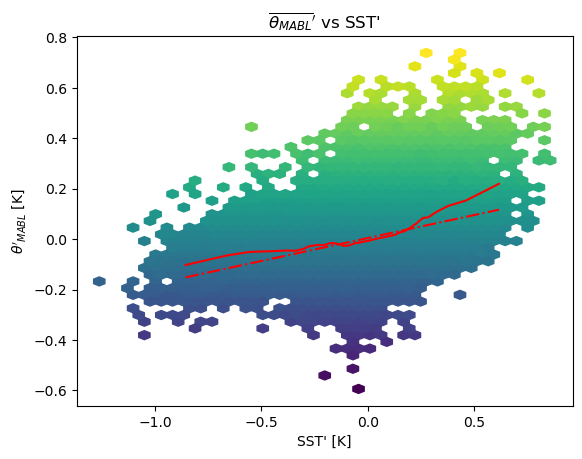

In [29]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dTheta_avg[::nt,::nskip,::nskip].flatten()

fit_dsens_dsst, corcoe_dsens_dsst, p_value_dsens_dsst, p_value_cannelli_dsens_dsst, sigmas_coeffs_dsens_dsst =\
slopes_r_p_mix(dsst_day, dTheta_avg, nt, nskip)

print(f"slope coeff = {fit_dsens_dsst.slope:.2f} K/K")

plt.hexbin(x,y,C=y, gridsize=(40,25))
plt.plot(pdist_dsst, pdist_ThetaAvg_dsst, color='red')
plt.plot(pdist_dsst, fit_dsens_dsst.slope*pdist_dsst+fit_dsens_dsst.intercept, color='red', linestyle='-.')

plt.title(r"$\overline{\theta_{MABL}}'$ vs SST'")
plt.xlabel("SST' [K]")
plt.ylabel(r"$\theta'_{MABL}$ [K]")

## $\int_{MABL} QVAPOR$

In [30]:
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_M':-1, 'x_grid_M':-1})
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

QVAPOR = QVAPOR.resample(time_counter='24H').mean(dim = 'time_counter')
QVAPOR = QVAPOR.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M')

In [31]:
QVAPOR = QVAPOR.assign_coords({'time_counter': PBLH_exp.time_counter})
QVAPOR = QVAPOR.where(under_mabl, drop=False).mean(dim='lev_M', skipna=True)

In [33]:
QVAPOR = QVAPOR.values*1e3

In [34]:
s = 75

dsst_day = np.zeros(sst_day.shape)
dQvapAvg = np.zeros(QVAPOR.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t], s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    q_ave = gm.nan_gaussian_filter(QVAPOR[t], s)                             
    dQvapAvg[t] = QVAPOR[t] - q_ave

0
10
20


In [35]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dQvapAvg_dsst, pstd_dQvapAvg_dsst, pstderr_dQvapAvg_dsst, pnpoints_dQvapAvg_dsst, ppvalue_dQvapAvg_dsst = \
distrib_2d(dsst_day, dQvapAvg, perc_step, nbins, popmean, 'perc')

slope coeff = -0.11 K/K


Text(0, 0.5, "$Q'_{QVap}$ [K]")

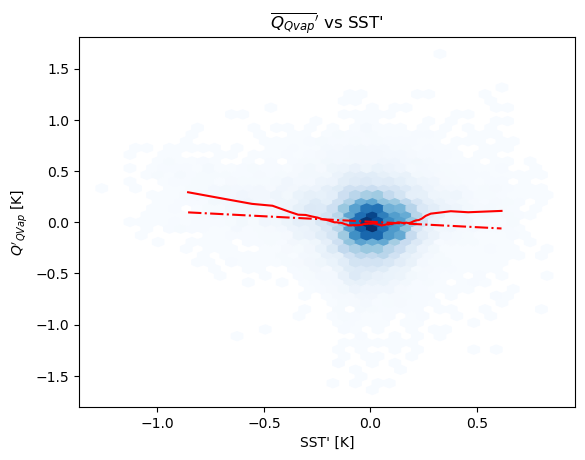

In [44]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dQvapAvg[::nt,::nskip,::nskip].flatten()

fit_dQvapAvg_dsst, corcoe_dQvapAvg_dsst, p_value_dQvapAvg_dsst, p_value_cannelli_dQvapAvg_dsst, sigmas_coeffs_dQvapAvg_dsst =\
slopes_r_p_mix(dsst_day, dQvapAvg, nt, nskip)

print(f"slope coeff = {fit_dQvapAvg_dsst.slope:.2f} K/K")

plt.hexbin(x,y, gridsize=(40,25), mincnt=1, cmap='Blues')
plt.plot(pdist_dsst, pdist_dQvapAvg_dsst, color='red')
plt.plot(pdist_dsst, fit_dQvapAvg_dsst.slope*pdist_dsst+fit_dQvapAvg_dsst.intercept, color='red', linestyle='-.')

plt.title(r"$\overline{Q_{Qvap}}'$ vs SST'")
plt.xlabel("SST' [K]")
plt.ylabel(r"$Q'_{QVap}$ [K]")

## $\int_{MABL} WINDSPEED$

In [45]:
# load U component
U = xr.open_dataset(wrf_files[files_ls.index('U.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_U':-1, 'x_grid_U':-1})
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [46]:
U

<xarray.DataArray 'U' (time_counter: 232, lev_M: 39, y_grid_U: 546,
                       x_grid_U: 574)>
dask.array<getitem, shape=(232, 39, 546, 574), dtype=float32, chunksize=(1, 1, 546, 574), chunktype=numpy.ndarray>
Coordinates:
  * time_counter    (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... 202...
    nav_lon_grid_U  (y_grid_U, x_grid_U) float32 dask.array<chunksize=(546, 574), meta=np.ndarray>
    nav_lat_grid_U  (y_grid_U, x_grid_U) float32 dask.array<chunksize=(546, 574), meta=np.ndarray>
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
Dimensions without coordinates: y_grid_U, x_grid_U
Attributes:
    long_name:           x-wind component
    units:               m s-1
    online_operation:    average
    interval_operation:  12 s
    interval_write:      3 h
    cell_methods:        time: mean (interval: 12 s) time_counter: mean

In [47]:
# i = np.arange(0, sea_mask.shape[1])
# U = 0.5*(U[:,:,:,i] + U[:,:,:,i+1])
U_lower = U.isel(x_grid_U=slice(0, -1))
U_upper = U.isel(x_grid_U=slice(1, None))

U = 0.5*(U_lower+U_upper)
U = U.rename({'y_grid_U':'y_grid_M', 'x_grid_U':'x_grid_M'})

<xarray.DataArray 'U' (time_counter: 232, lev_M: 39, y_grid_U: 546,
                       x_grid_U: 573)>
dask.array<mul, shape=(232, 39, 546, 573), dtype=float32, chunksize=(1, 1, 546, 573), chunktype=numpy.ndarray>
Coordinates:
  * time_counter    (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... 202...
    nav_lat_grid_U  (y_grid_U, x_grid_U) float32 5.416 5.416 ... 15.23 15.23
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
Dimensions without coordinates: y_grid_U, x_grid_U

In [53]:
# load U component
V = xr.open_dataset(wrf_files[files_ls.index('V.nc')], chunks={'time_counter':1, 'lev_M':1, 'y_grid_V':-1, 'x_grid_V':-1})
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

V_lower = V.isel(y_grid_V=slice(0, -1))
V_upper = V.isel(y_grid_V=slice(1, None))

V = 0.5*(V_lower+V_upper)
V = V.rename({'y_grid_V':'y_grid_M', 'x_grid_V':'x_grid_M'})

In [54]:
U = U.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M' )
V = V.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M' )

U = U.where(sea_mask_modified, drop=False)
V = V.where(sea_mask_modified, drop=False)

In [55]:
wind_sp = ((U**2)+(V**2))**(0.5)
wind_sp = wind_sp.resample(time_counter='24H').mean(dim='time_counter')

In [57]:
wind_sp = wind_sp.assign_coords({'time_counter': PBLH_exp.time_counter})
wind_sp_mabl = wind_sp.where(under_mabl, drop=False).mean(dim='lev_M', skipna=True)

In [58]:
wind_sp_mabl = wind_sp_mabl.values

KeyboardInterrupt: 

In [ ]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_WsSST, pstd_WsSST, pstderr_WsSST, pnpoints_WsSST, ppvalue_WsSST = \
distrib_2d(sst_day, wind_sp_mabl, perc_step, nbins, popmean, 'perc')

In [ ]:
s = 75

dsst_day = np.zeros(sst_day.shape)
dws = np.zeros(wind_sp_mabl.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t], s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    ws_ave = gm.nan_gaussian_filter(wind_sp_mabl[t], s)                             
    dws[t] = wind_sp_mabl[t] - ws_ave

In [ ]:
perc_step = 1
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dWsdSST, pstd_dWsdSST, pstderr_dWsdSST, pnpoints_dWsdSST, ppvalue_dWsdSST = \
distrib_2d(dsst_day, dws, perc_step, nbins, popmean, 'perc')

In [ ]:
x = dsst_day[::nt,::nskip,::nskip].flatten()
y = dQvapAvg[::nt,::nskip,::nskip].flatten()

fit_dQvapAvg_dsst, corcoe_dQvapAvg_dsst, p_value_dQvapAvg_dsst, p_value_cannelli_dQvapAvg_dsst, sigmas_coeffs_dQvapAvg_dsst =\
slopes_r_p_mix(dsst_day, dQvapAvg, nt, nskip)

print(f"slope coeff = {fit_dQvapAvg_dsst.slope:.2f} K/K")

plt.hexbin(x,y, gridsize=(40,25), mincnt=1, cmap='Blues')
plt.plot(pdist_dsst, pdist_dQvapAvg_dsst, color='red')
plt.plot(pdist_dsst, fit_dQvapAvg_dsst.slope*pdist_dsst+fit_dQvapAvg_dsst.intercept, color='red', linestyle='-.')

plt.title(r"$\overline{Q_{Qvap}}'$ vs SST'")
plt.xlabel("SST' [K]")
plt.ylabel(r"$Q'_{QVap}$ [K]")